<a href="https://colab.research.google.com/github/shivendr7/ml/blob/GANs/ACGAN_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Flatten, Input, Concatenate, BatchNormalization, Activation, LeakyReLU, Dense, Embedding, Reshape, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

In [2]:
(train_images, train_labels), (test_images, test_labels)=fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [3]:
def build_generator(latent_dim):
  init=RandomNormal(stddev=0.02)
  inpN=Input(shape=(latent_dim,))
  g1=Dense(384*7*7, kernel_initializer=init)(inpN)
  g1=Activation('relu')(g1)
  g1=Reshape(target_shape=(7,7,384))(g1)
  inpL=Input(shape=(1,))
  g2=Embedding(input_dim=10, output_dim=50)(inpL)
  g2=Dense(49, kernel_initializer=init)(g2)
  g2=Reshape(target_shape=(7,7,1))(g2)
  g=Concatenate()([g1, g2])
  g=Conv2DTranspose(192, kernel_size=(5,5), strides=(2,2), padding='same', kernel_initializer=init)(g)
  g=BatchNormalization()(g)
  g=Activation('relu')(g)
  g=Conv2DTranspose(1, kernel_size=(5,5), strides=(2,2), padding='same', kernel_initializer=init)(g)
  out=Activation('tanh')(g)
  model=Model(inputs=[inpN, inpL], outputs=out)
  return model
gen=build_generator(100)

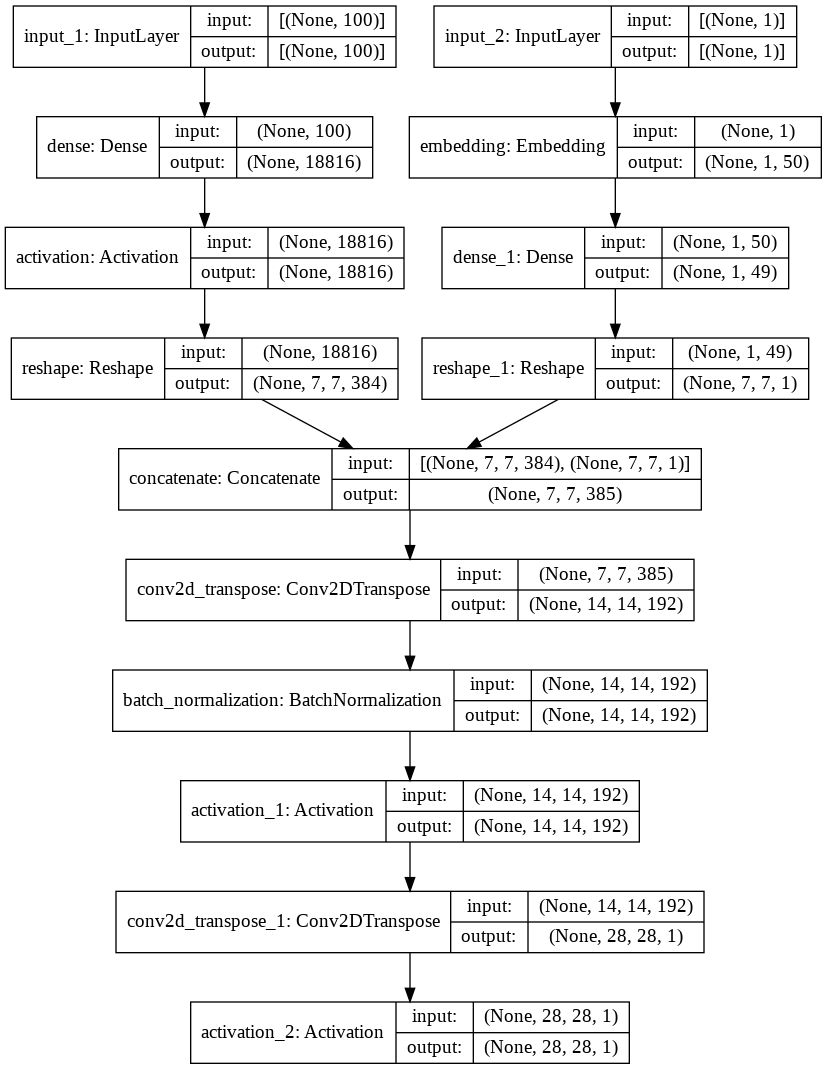

In [4]:
from keras.utils.vis_utils import plot_model
plot_model(gen, show_shapes=True, show_layer_names=True)

In [5]:
def build_discriminator():
  init=RandomNormal(stddev=0.02)
  inp=Input(shape=(28,28,1))
  d=Conv2D(32, kernel_size=(3,3), strides=(2,2), padding='same', kernel_initializer=init)(inp)
  d=LeakyReLU(alpha=0.2)(d)
  d=Dropout(rate=0.5)(d)
  d=Conv2D(64, kernel_size=(3,3), padding='same', kernel_initializer=init)(d)
  d=BatchNormalization()(d)
  d=LeakyReLU(alpha=0.2)(d)
  d=Dropout(rate=0.5)(d)
  d=Conv2D(128, kernel_size=(3,3), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d=BatchNormalization()(d)
  d=LeakyReLU(alpha=0.2)(d)
  d=Dropout(rate=0.5)(d)
  d=Conv2D(256, kernel_size=(3,3), padding='same', kernel_initializer=init)(d)
  d=BatchNormalization()(d)
  d=LeakyReLU(alpha=0.2)(d)
  d=Dropout(rate=0.5)(d)
  d=Flatten()(d)
  out1=Dense(1, activation='sigmoid')(d)
  out2=Dense(10, activation='softmax')(d)
  model=Model(inputs=inp, outputs=[out1, out2])
  opt=Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt, metrics=['accuracy'])
  return model
disc=build_discriminator()

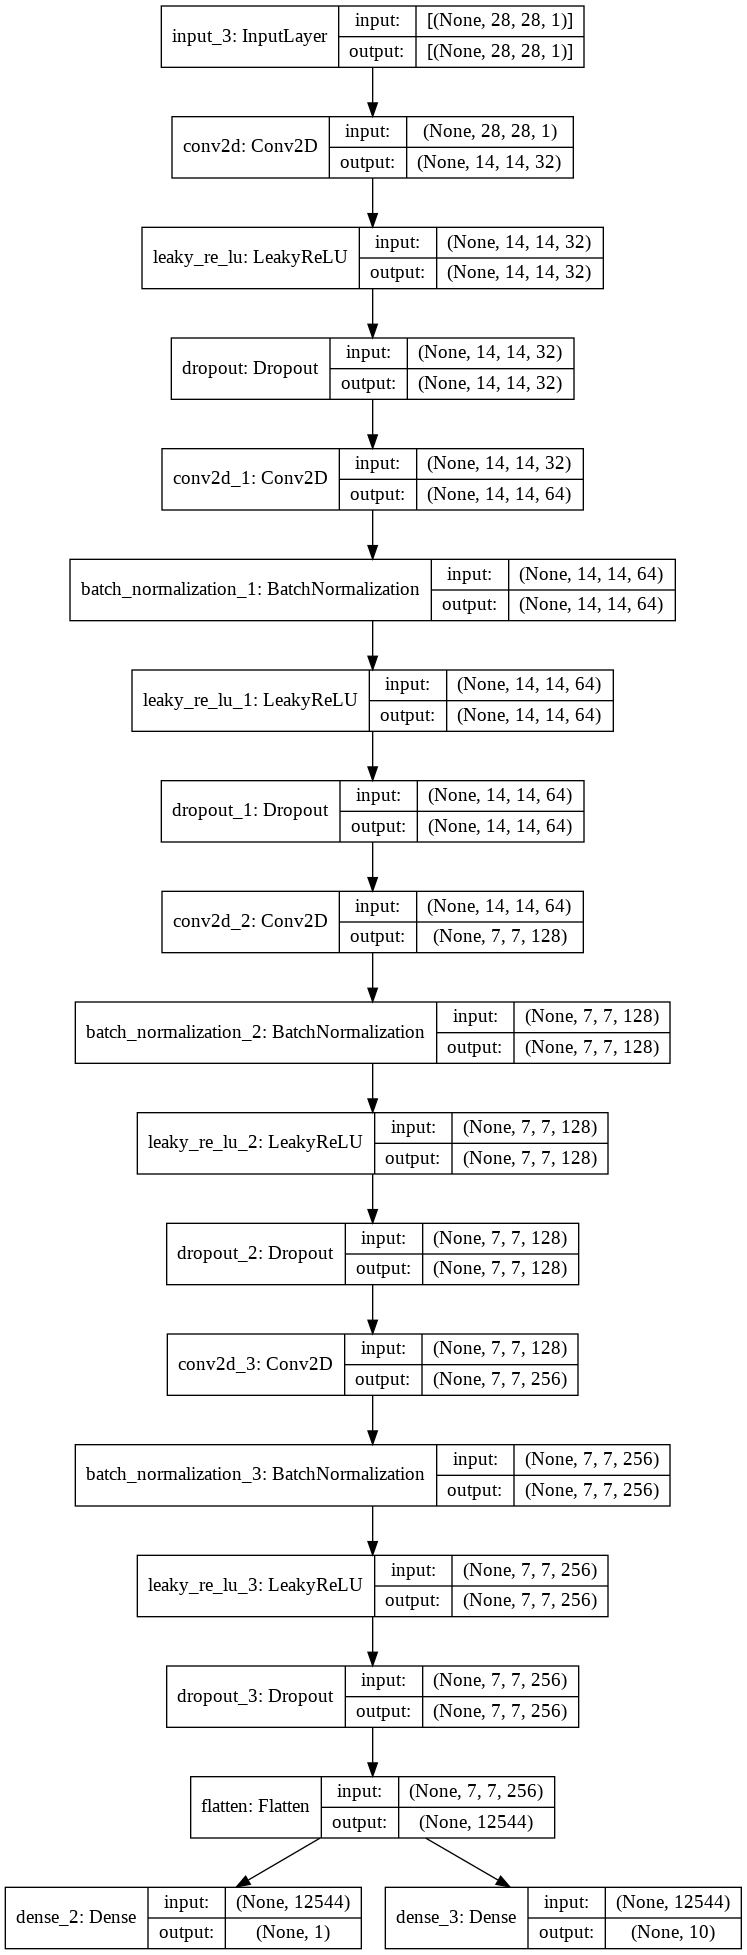

In [6]:
plot_model(disc, show_shapes=True, show_layer_names=True, expand_nested=True)

In [7]:
def build_gan():
  disc.trainable=False
  out=disc(gen.output)
  model=Model(inputs=gen.input, outputs=out)
  opt=Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt, metrics=['accuracy'])
  return model
gan=build_gan()

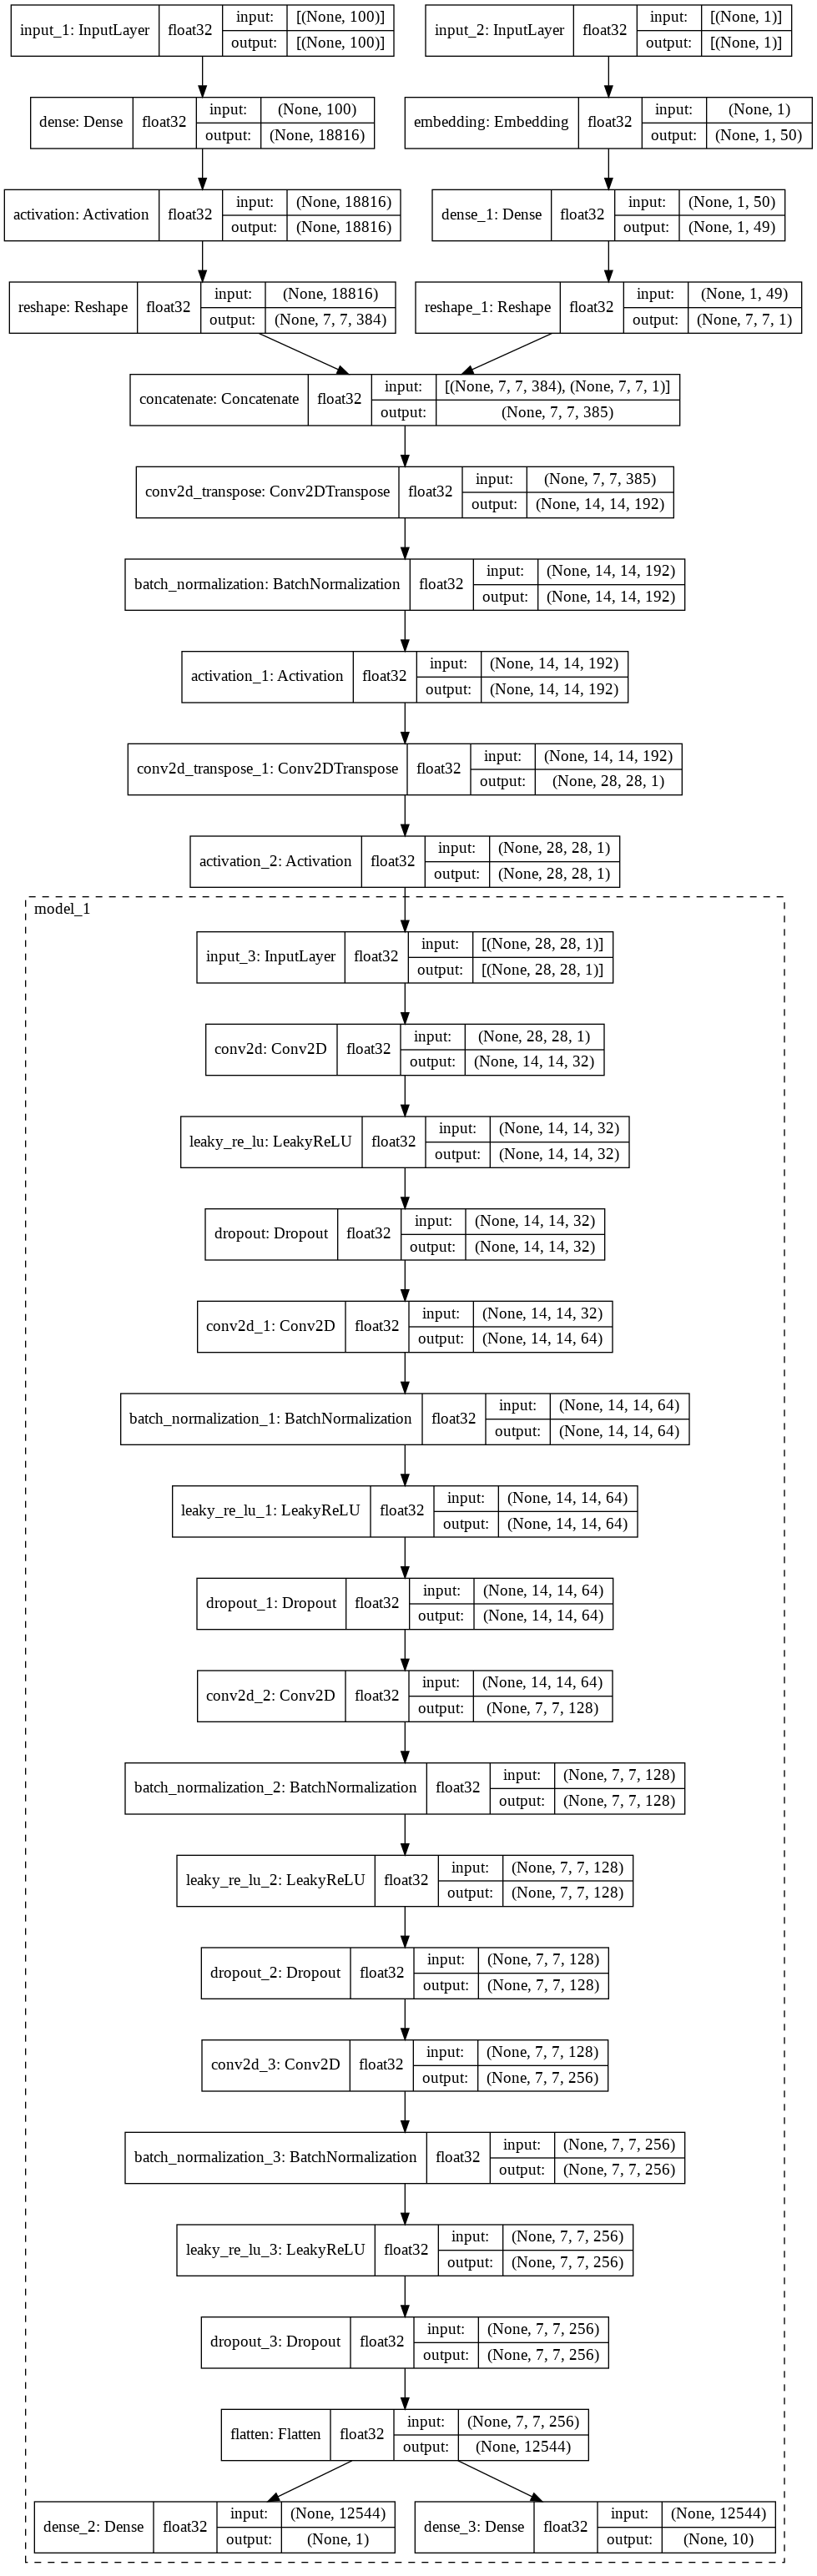

In [8]:
plot_model(gan, show_shapes=True, show_layer_names=True, show_dtype=True, expand_nested=True)

In [9]:
disc.predict(train_images[0].reshape(1,28,28,1))

[array([[0.5902884]], dtype=float32),
 array([[0.09058591, 0.09707213, 0.13625143, 0.09665466, 0.0709416 ,
         0.07377705, 0.06694569, 0.16040331, 0.1125044 , 0.09486373]],
       dtype=float32)]

In [10]:
X=np.expand_dims(train_images, axis=-1)
Xf=train_images.astype('float32')
Xf=(Xf-127.5)/127.5

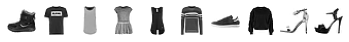

In [11]:
for i in range(10):
  plt.subplot(1,10,i+1)
  plt.axis('off')
  plt.imshow(Xf[i], cmap='gray_r')

In [12]:
def generate_real_samples(n_samples):
  ix=np.random.randint(0, Xf.shape[0], n_samples)
  x1=Xf[ix]
  x2=train_labels[ix]
  y=np.ones(shape=(n_samples,1))
  return [x1,x2],y
[x_1,x_2],y=generate_real_samples(10)
x_1.shape, x_2.shape, y.shape

((10, 28, 28), (10,), (10, 1))

In [13]:
def generate_latent_points(n_samples):
  noise=np.random.randn(100*n_samples)
  noise=noise.reshape(n_samples, 100)
  labels=np.random.randint(0, 10, n_samples)
  return noise, labels
def generate_fake_samples(n_samples):
  n, l=generate_latent_points(n_samples)
  x1=gen.predict([n, l])
  y=np.zeros(shape=(n_samples, 1))
  return [x1, l], y
[x_1, x_2], y_1=generate_fake_samples(10)
x_1.shape, x_2.shape, y.shape

((10, 28, 28, 1), (10,), (10, 1))

In [14]:
d_fakeI, d_fakeL, d_realI, d_realL, g_LI, g_LL=[],[],[],[],[],[]

In [25]:
def summarise_performance(step):
  [x,_], _=generate_fake_samples(5)
  for i in range(5):
    plt.subplot(11, step+1, step*5+i)
    plt.axis('off')
    plt.imshow(x[i].reshape(28,28), cmap='gray_r')

In [26]:
def train(n_epochs=100, n_batch=64):
  batch_per_epochs=Xf.shape[0]//n_batch
  half_batch=n_batch//2
  n=batch_per_epochs*n_epochs
  for i in range(100):
    [x_r, x_l], y_r=generate_real_samples(half_batch)
    d_loss1, d_loss11, d_loss12, _, _=disc.train_on_batch(x_r, [y_r, x_l])
    [x_f, x_l], y_f=generate_fake_samples(half_batch)
    d_loss2, d_loss21, d_loss22, _, _=disc.train_on_batch(x_f, [y_f, x_l])
    N,L=generate_latent_points(n_batch)
    Y=np.ones(shape=(n_batch,1))
    g_loss, g_loss11, g_loss12, _, _=gan.train_on_batch([N, L], [Y, L])
    d_realI.append(d_loss11)
    d_realL.append(d_loss12)
    d_fakeI.append(d_loss21)
    d_fakeL.append(d_loss22)
    g_LI.append(g_loss11)
    g_LL.append(g_loss12)
    if (i+1)%10==0:
      summarise_performance((i+1)//10)
    print('%d fake[%.3f, %.3f] real[%.3f, %.3f] ganL[%.3f, %.3f]'%(i+1, d_loss21, d_loss22, d_loss11, d_loss12, g_loss11, g_loss12))

1 fake[0.150, 3.442] real[0.191, 1.416] ganL[1.196, 2.682]
2 fake[0.154, 3.404] real[0.115, 1.053] ganL[1.201, 2.451]
3 fake[0.154, 3.110] real[0.169, 0.913] ganL[1.209, 2.466]
4 fake[0.249, 2.931] real[0.139, 1.157] ganL[1.295, 2.672]
5 fake[0.135, 2.522] real[0.055, 0.987] ganL[1.366, 2.586]
6 fake[0.208, 3.383] real[0.187, 1.241] ganL[1.348, 2.691]
7 fake[0.232, 2.858] real[0.207, 1.112] ganL[1.366, 2.538]
8 fake[0.356, 2.725] real[0.132, 0.894] ganL[1.396, 2.593]
9 fake[0.210, 3.480] real[0.148, 1.530] ganL[1.529, 2.694]
10 fake[0.118, 2.940] real[0.372, 0.922] ganL[1.507, 2.553]
11 fake[0.221, 3.427] real[0.218, 1.172] ganL[1.414, 2.672]
12 fake[0.153, 3.347] real[0.339, 0.991] ganL[1.388, 2.435]
13 fake[0.109, 3.094] real[0.252, 1.296] ganL[1.393, 2.523]
14 fake[0.163, 2.838] real[0.312, 0.786] ganL[1.419, 2.457]
15 fake[0.150, 2.679] real[0.138, 1.287] ganL[1.418, 2.576]
16 fake[0.173, 2.916] real[0.141, 0.840] ganL[1.445, 2.507]
17 fake[0.073, 3.226] real[0.224, 1.002] ganL[1.4

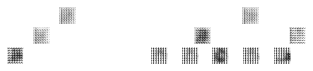

In [27]:
train()

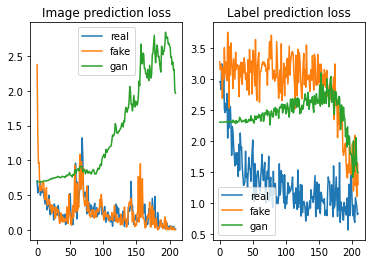

In [28]:
def plot_history():
  plt.subplot(1,2,1)
  plt.plot(d_realI, label='real')
  plt.plot(d_fakeI, label='fake')
  plt.plot(g_LI, label='gan')
  plt.title(label='Image prediction loss')
  plt.legend()
  plt.subplot(1,2,2)
  plt.plot(d_realL, label='real')
  plt.plot(d_fakeL, label='fake')
  plt.plot(g_LL, label='gan')
  plt.title(label='Label prediction loss')
  plt.legend()
plot_history()

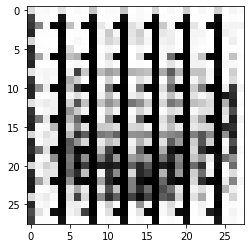

In [35]:
[x, _], _=generate_fake_samples(2)
plt.imshow(x[0].reshape(28,28), cmap='gray_r')